### Import Standard Libraries and make random numbers predictable

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

/Users/miguelvalarao/.pyenv/versions/3.7.6/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/miguelvalarao/.pyenv/versions/3.7.6/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Import Sklearn Libraries

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

### Import wine quality data as dataframe

In [3]:
df = pd.read_csv('./winequality-red.csv')

### Set target Y as 'quality' and X values

In [4]:
Y = df['quality']
X = df[
    [
        'fixed acidity',
        'volatile acidity',
        'citric acid',
        'residual sugar',
        'chlorides',
        'free sulfur dioxide',
        'total sulfur dioxide',
        'density',
        'pH',
        'sulphates',
        'alcohol'
    ]
]

### Split data, build model, and fit

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

### Import and initialize shap

In [6]:
import shap
shap.initjs()

### Get SHAP values

In [7]:
shap_values = shap.TreeExplainer(model).shap_values(X_train)

### Variable Importance Bar Graph (Global Interpretability)

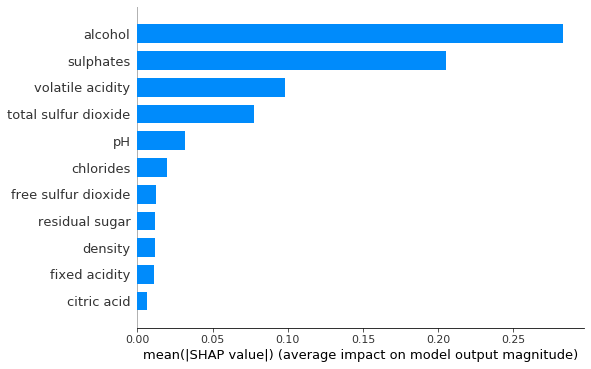

In [8]:
shap.summary_plot(shap_values, X_train, plot_type='bar')

In [9]:
def abs_shap(df_shap, df):
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i], df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list), pd.Series(corr_list)], axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable', 'Corr']
    corr_df['Sign'] = np.where(corr_df['Corr'] > 0, 'red', 'blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k = pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable', 'SHAP_abs']
    k2 = k.merge(corr_df, left_on = 'Variable', right_on='Variable', how='inner')
    k2 = k2.sort_values(by='SHAP_abs', ascending=True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable', y='SHAP_abs', color=colorlist, figsize=(5, 6), legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")

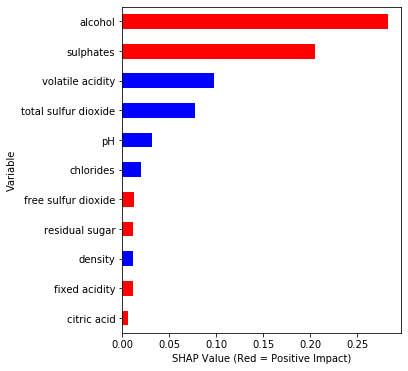

In [10]:
abs_shap(shap_values, X_train) 

### Variable Importance Plot (Global Interpretability)

- ```Feature importance```: Variables are ranked in descending order.
- ```Impact```: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
- ```Original value```: Color shows whether that variable is high (in red) or low (in blue) for that observation.
- ```Correlation```: A high level of the “alcohol” content has a high and positive impact on the quality rating. The “high” comes from the red color, and the “positive” impact is shown on the X-axis. Similarly, we will say the “volatile acidity” is negatively correlated with the target variable.

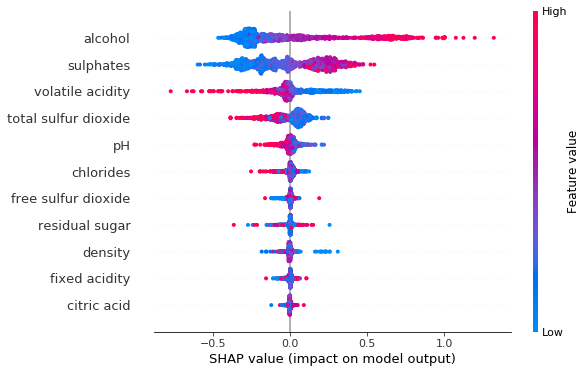

In [11]:
shap.summary_plot(shap_values, X_train)

### Variable Dependence Plot - Alcohol (Global Interpretability)

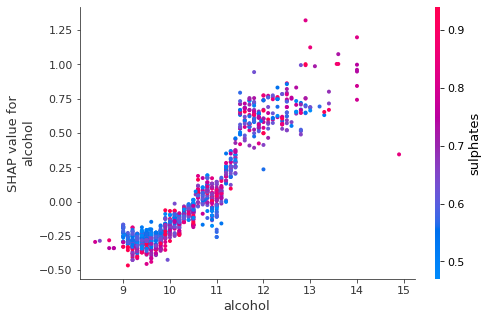

In [12]:
shap.dependence_plot("alcohol", shap_values, X_train)

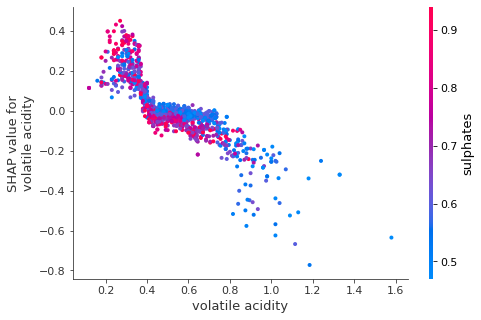

In [13]:
shap.dependence_plot('volatile acidity', shap_values, X_train)

### Get the predictions and put them with the test data

In [14]:
X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(model.predict(X_output),2)

### Randomly pick observations

In [15]:
random_picks = np.arange(1,330,50)
S = X_output.iloc[random_picks]
S

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,predict
1032,8.1,0.820,0.00,4.1,0.095,5.0,14.0,0.99854,3.36,0.53,9.6,4.50
34,5.2,0.320,0.25,1.8,0.103,13.0,50.0,0.99570,3.38,0.55,9.2,5.35
1508,7.1,0.270,0.60,2.1,0.074,17.0,25.0,0.99814,3.38,0.72,10.6,6.26
1479,8.2,0.280,0.60,3.0,0.104,10.0,22.0,0.99828,3.39,0.68,10.6,5.93
866,6.8,0.490,0.22,2.3,0.071,13.0,24.0,0.99438,3.41,0.83,11.3,6.33
1519,6.6,0.700,0.08,2.6,0.106,14.0,27.0,0.99665,3.44,0.58,10.2,5.47
1193,6.4,0.885,0.00,2.3,0.166,6.0,12.0,0.99551,3.56,0.51,10.8,4.51


### Define SHAP Plot function

In [16]:
def shap_plot(j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

### Individual Observation SHAP Plot

In [17]:
shap_plot(0)